# Piotr Szymajda - 273023

# Lab 6: Light Fields

Inspired on the HW6 of the EECS 395/495: Introduction to Computational Photography (Northwestern University)

In this homework, you will capture a light field by waving your cell phone camera around. The goal of this homework is to synthesize an image that appears to be captured from a synthetic aperture that is much larger aperture than your cell phone camera [1]. The advantage of this technique is that captured images can have a significantly smaller depth of field, giving the look and feel of a much more expensive camera. The other advantage is that, because we are capturing a light field, we can digitally refocus the image. The disadvantage of this technique is that, because it relies on sequential image capture, it will only work for static scenes. The technique requires the image sequence to be registered, and the quality of the final photograph will be limited by how well the images can be registered. In this homework, we will use a simple auto-correlation based registration scheme.

In [1]:
#some magic to show the images inside the notebook
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import ndimage
import imageio as imio
import numpy as np
import subprocess
from copy import deepcopy

# A hepler function for displaying images within the notebook.
# It displays an image, optionally applies zoom the image.
def show_image(img, zoom=1.5):
    dpi = 77
    plt.figure(figsize=(img.shape[0]*zoom/dpi,img.shape[0]*zoom/dpi))
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis],3,2)        
    plt.imshow(img, interpolation='nearest')
    

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_images(imglist, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77 # pyplot default?
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    

Populating the interactive namespace from numpy and matplotlib


## Task 1: Capture an unstructured light field (20 points)


You will capture a video as you wave your camera around in front of a static scene. Here are some guidelines.
 
1.    You need to avoid tilting and rotating the camera as much as possible. You should just shift the camera in a plane (see Figure 1). You may need to try this several times before you capture a good video.

2.    You may want to press the phone against a flat object to help guide the planar motion

3.    We might want to use a zig-zag motion In general, the more you cover the plane, the better your results in the next section will be.

![alt text](imgs/image1.png)

4.    Make sure your video is not too long. You should capture a few seconds of video.
5.    Capture a scene with a few objects at different depths one object with enough depth. See [Stanford LF repository](http://lightfield.stanford.edu/lfs.html) for examples. In the next section you will create narrow synthetic aperture images that are focused on these objects
6.    Make sure that all of the objects in the scene are in focus. As long as objects are about a meter in size and 1-2 meters away, they will more or less be in focus.


## Task 2: Process video and extract frames (30 points)

Once you have captured a video, we need to register frames of captured video and generate our LF. 

You should be able to use imageio to load a video and convert it to frames. Have a look to [Examples](http://imageio.readthedocs.io/en/latest/examples.html). The idea is to select a number of frames to create a LF. Anything between 7x7 and 11x11 will be fine. 

When you save the frames, you might want to reduce the resolution too, and maybe crop to the area of interest, to make it easier to handle later. Arround 400 pixels will be enough. 

Here an example of an actual lightfield capture with Lytro (GIL, University of Zaragoza)

![alt text](imgs/frog.jpg)

Note that if you recorded about 1 minute of video, this means 1800 frames, which is not nice to select frames manually!! So you might want to look at your video before in VLC and pre-select the images before saving them. 

YOU DON'T NEED TO CREATE A SINGLE IMAGE FOR YOUR LF


In [2]:
import imageio
imageio.plugins.ffmpeg.download()

In [3]:
import imageio

reader = imageio.get_reader('./video/video3.mp4')

print('No. of frames = %i' % len(reader))

frames = []

for i, im in enumerate(reader):
#    print('Mean of frame %i is %1.1f' % (i, im.mean()))
    if i % 4 == 0:
        frames.append(im)
    
    # hack to get more frames (from 79 to 81)
    if i > 311:
        frames.append(im)

#print(frames)
print('No. of selected frames = %i' % len(frames))

ys = 400
xs = 200
size = 800

          #     400:1200,  200:1000
cropped = [im[ys:ys+size,xs:xs+size] for im in frames[:81]]

No. of frames = 315
No. of selected frames = 81


/pio/os/anaconda/lib/python2.7/site-packages/imageio/core/format.py:392: UserWarning: Could not read last frame of /home/i273023/Repos/compho/Lab6/video/video3.mp4.
  warn('Could not read last frame of %s.' % uri)


for i in range(9):
   show_images(cropped[9*i:9*(i+1)])       

allimg = np.zeros([9*size, 9*size, 3])

for i in range(9):
    for j in range(9):
        allimg[i*size:(i+1)*size,j*size:(j+1)*size] = cropped[9*i+j]
        
show_image(allimg)

In [4]:
templateBig = cropped[0][550:650,200:300]
template = cropped[0][570:602,240:272]
show_image(templateBig)
show_image(template)


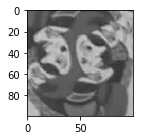

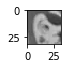

In [4]:
gray_frames = []

for im in frames:
    r, g, b = im[:,:,0], im[:,:,1], im[:,:,2]
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)/255.
    gray_frames.append(gray)
    

templateBig = gray_frames[0][ys+550:ys+650,xs+200:xs+300]
template = gray_frames[0][ys+570:ys+602,xs+240:xs+272]
show_image(templateBig)
show_image(template)


## Task 3.1: Register the frames of video using template matching (70 points)

Registration should be performed on grayscale video frames. You will use a simple template-matching scheme. Here is what you need to do:
 
1.    Convert each frame of your video to grayscale

![alt text](imgs/image2.png)

2.    The red box in the figure shows the template that was used for registration. You will need to select a similar template from the first frame of your video. You will then search for a match to this template in successive frames. The location of the match will tell you how many pixels your camera has shifted. Choose a size for this template (i.e. 16x16 pixels). You may need to adjust this to improve your results.

![alt text](imgs/image3.png)

4.    You only need to search for a template match within a window of your target frame. The window should be centered on the location of the template in the first frame. 


5. So you need to compare the template with all possible possitions within the window search and find the one that is most similar. You can use Normalized Cross Correlation, or Sum of Square Distances, or other metric of your choice. This should give you the estimated position (translation) of each image with respect to the reference frame. Some thing like this:

![alt text](imgs/image4.jpg)


In [5]:
from scipy.ndimage.interpolation import shift

96.7698507332
0
152.277959943
1
172.77678922
2
107.806959951
3
76.301098562
4
48.9272607124
5
60.2376406371
6
35.0286678184
7
33.2448123896
8
36.1563199389
9
51.5124043231
10
96.9375271212
11
143.215869863
12
168.381277465
13
198.716976645
14
216.751559841
15
218.417243414
16
188.509850586
17
151.048424256
18
94.6699967404


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


19
65.2165669412
20
44.1549199385
21
33.9161217959
22
29.9210360023
23
30.0376001876
24
27.6514489546
25
30.2220956128
26
32.0643845044
27
39.3648973047
28
46.1204354244
29
69.6367759707
30
109.214371538
31
118.191452165
32
119.215295178
33
104.48071598
34
61.2889020483
35
60.2428792715
36
44.7080278788
37
28.2713669168
38
34.7019864939
39
33.9196934199
40
37.0271045212
41
44.7884257925
42
45.9959180978
43
29.6888472155
44
78.1607090059
45
144.832359203
46
219.357147258
47
216.061141086
48
197.461510701
49
183.034555586
50
167.884077061
51
159.838335921
52
148.742761682
53
135.728607058
54
120.181321792
55
110.656361287
56
103.536494309
57
97.5476338937
58
93.7426632867
59
91.3267782573
60
90.4517569718
61
92.0920585897
62
96.3016282907
63
106.68195702
64
108.35016081
65
96.1562869075
66
89.7000315959
67
106.326994968
68
141.248506168
69
151.983765969
70
157.406864349
71
169.749062328
72
191.257509716
73
205.911868188
74
214.017929869
75
217.777782209
76
172.874153983
77
149.254413542


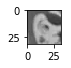

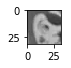

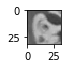

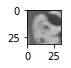

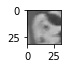

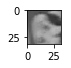

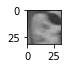

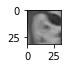

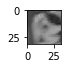

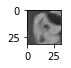

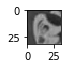

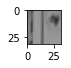

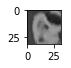

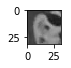

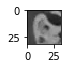

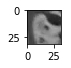

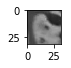

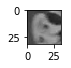

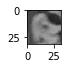

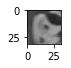

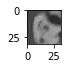

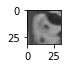

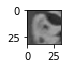

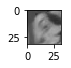

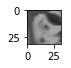

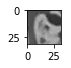

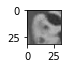

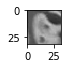

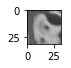

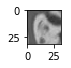

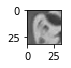

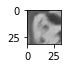

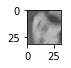

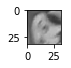

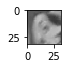

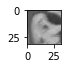

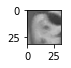

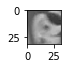

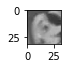

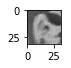

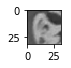

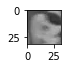

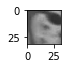

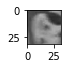

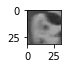

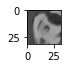

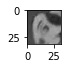

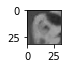

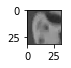

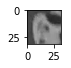

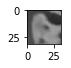

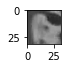

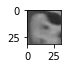

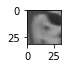

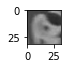

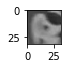

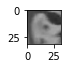

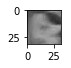

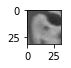

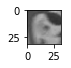

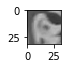

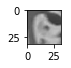

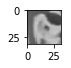

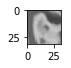

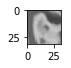

In [64]:
show_image(template)

it = 0

points = []
for im in gray_frames:
    crop = im[ys:ys+size,xs:xs+size]   
    cs = np.sum((crop[0:32,0:32] - template)**2)
    print cs
    
    cx, cy = 0, 0
    
    for x in range(size-32):
        for y in range(size-32):
            tmp = np.sum((crop[y:y+32,x+0:x+32] - template)**2)
            if tmp < cs:
                cx, cy = x, y
                cs = tmp
                
    #show_image(crop[cy:cy+32,cx:cx+32])
    #show_image(crop)
    
    points+=[[ys+cy,xs+cx]]
    print it
    it += 1

print points
            

In [6]:
points_backup = [[970, 440], [972, 454], [972, 472], [971, 493], [969, 516], [966, 540], [967, 568], [968, 597], [969, 624], [969, 650], [963, 676], [953, 695], [946, 706], [942, 714], [935, 724], [977, 654], [900, 737], [881, 729], [870, 720], [862, 705], [856, 687], [851, 669], [847, 650], [843, 628], [843, 609], [849, 590], [851, 573], [851, 554], [852, 537], [853, 524], [851, 512], [854, 497], [858, 480], [858, 465], [854, 452], [851, 438], [847, 422], [839, 406], [830, 391], [823, 382], [814, 376], [805, 375], [798, 380], [783, 387], [768, 397], [750, 412], [735, 433], [725, 456], [719, 484], [715, 512], [710, 534], [705, 552], [701, 570], [702, 592], [703, 616], [703, 641], [698, 660], [685, 671], [675, 680], [661, 691], [643, 693], [624, 684], [610, 667], [603, 640], [596, 606], [593, 580], [589, 558], [586, 534], [589, 512], [589, 485], [589, 458], [588, 432], [588, 407], [590, 385], [592, 365], [593, 348], [591, 331], [589, 320], [586, 312], [586, 312], [584, 310]]

In [66]:
import pickle
with open("dump", 'wb') as f:
    pickle.dump(points, f)

In [14]:
def find_template(frames_for_search):
    points = []
    for im in frames_for_search:
        crop = im[ys:ys+size,xs:xs+size]   
        cs = np.sum((crop[0:32,0:32] - template)**2)
        print cs

        cx, cy = 0, 0

        for x in range(size-32):
            for y in range(size-32):
                tmp = np.sum((crop[y:y+32,x+0:x+32] - template)**2)
                if tmp < cs:
                    cx, cy = x, y
                    cs = tmp

        show_image(crop[cy:cy+32,cx:cx+32])
        #show_image(crop)

        points+=[[ys+cy,xs+cx]]

    return points

In [15]:
import concurrent.futures

proc = 12
img_per_chunk = (81 + proc - 1) / proc

print img_per_chunk

data = [gray_frames[img_per_chunk*i:img_per_chunk*(i+1)] for i in range(proc-1)]
data.append(gray_frames[img_per_chunk*(proc-1):])

output = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    out = executor.map(find_template, data)
    
    for p in range(proc):
        output += out.next()
    
    print output
    points = output

6
96.7698507332
60.2376406371
143.215869863
151.048424256
30.0376001876
69.6367759707
60.2428792715
44.7884257925
216.061141086
135.728607058
91.3267782573
96.1562869075
152.277959943
94.6699967404
35.0286678184
168.381277465
27.6514489546
109.214371538
45.9959180978
44.7080278788
197.461510701
120.181321792
90.4517569718
89.7000315959
172.77678922
65.2165669412
33.2448123896
30.2220956128
198.716976645
118.191452165
29.6888472155
28.2713669168
183.034555586
110.656361287
92.0920585897
106.326994968
107.806959951
32.0643845044
36.1563199389
216.751559841
44.1549199385
119.215295178
78.1607090059
96.3016282907
103.536494309
34.7019864939
167.884077061
141.248506168
33.9196934199
33.9161217959
76.301098562
39.3648973047
51.5124043231
104.48071598
159.838335921
218.417243414
106.68195702
144.832359203
97.5476338937
151.983765969
37.0271045212
48.9272607124
29.9210360023
46.1204354244
96.9375271212
148.742761682
61.2889020483
188.509850586
108.35016081
219.357147258
93.7426632867
157.40686

In [17]:
print output
points = output

[[[970, 440], [972, 454], [972, 472], [971, 493], [969, 516], [966, 540]], [[967, 568], [968, 597], [969, 624], [969, 650], [963, 676], [953, 695]], [[946, 706], [942, 714], [935, 724], [977, 654], [900, 737], [881, 729]], [[870, 720], [862, 705], [856, 687], [851, 669], [847, 650], [843, 628]], [[843, 609], [849, 590], [851, 573], [851, 554], [852, 537], [853, 524]], [[851, 512], [854, 497], [858, 480], [858, 465], [854, 452], [851, 438]], [[847, 422], [839, 406], [830, 391], [823, 382], [814, 376], [805, 375]], [[798, 380], [783, 387], [768, 397], [750, 412], [735, 433], [725, 456]], [[719, 484], [715, 512], [710, 534], [705, 552], [701, 570], [702, 592]], [[703, 616], [703, 641], [698, 660], [685, 671], [675, 680], [661, 691]], [[643, 693], [624, 684], [610, 667], [603, 640], [596, 606], [593, 580]], [[589, 558], [586, 534], [589, 512], [589, 485], [589, 458], [588, 432], [588, 407], [590, 385], [592, 365], [593, 348], [591, 331], [589, 320], [586, 312], [586, 312], [584, 310]]]


In [7]:
points = points_backup

In [22]:
pt_list= np.array(points)
plt.plot(pt_list[:,1], pt_list[:,0], "-or")

## Task 3.2: Create a synthetic aperture photograph (30 points)
 
Once you have calculated the pixel shift, you can generate a synthetic aperture photograph simply by shifting the images of each frame of video in the opposite direction and then summing up the result. This will be equivalent to focus on the plane where the template used for alignment is, with an apperture of the size of the max displacement. 


In [8]:
from scipy.ndimage.interpolation import shift

In [ ]:
# with open("dump", 'rb') as f:
#     dump_points = pickle.load(f)
#     points = dump_points 

image = shift(frames[0], (0,0,0), cval=0)
by, bx = points[0]

shift_frames = [image]

for i in range(1,len( frames)):
    y, x = points[i]
    temp_img = shift(frames[i], (by-y,bx-x,0), cval=0)
    
#     image= (image+temp_img)//2

    shift_frames.append(temp_img)
    
    print i
    show_image(temp_img, 0.5)
    
    

In [ ]:
result = np.zeros_like(shift_frames[0]).astype(float64)


for im in shift_frames:
    result += im

result /= 81.0

show_image(result.astype(uint8), 1)


## Task 4: Focal stack video/GIF (50 points)

Create images with focus at different distances using your light field. You can put them together in a short video/GIF (see imageio examples). 

You can do this first in the sample light field (frog.jpg). Use the center view. You simple have to shift away from the center, or towards the center by a distance proportional to the depth. Since your images are not uniformly sampled (as in the example light field (figure 2). 

The distance between views is the same, so the relationship between the displacements should be proportional. You can do this for a couple of apertures, 9 and 5 (for example). This will mean to average 17 or 5 pictures in each axis respectively.

Do the same for your light field. Now, since the sampling is not uniform, the distances that you need to shift the images is proportional to the displacement of a particular frame how far they are from the center.

Now, if you want to change the aperture, you need to change the images you use depending of the distance to the focus point. 

In [ ]:
writer = imageio.get_writer("video_result_30fps.mp4", fps=30)


for dist in np.linspace(-2,2,30):

    print dist
    
    image = shift(frames[0], (0,0,0), cval=0)
    by, bx = points[0]
    shift_frames_tmp = [image]

    for i in range(1,len( frames)):
        y, x = points[i]
        temp_img = shift(frames[i], ((by-y)*dist,(bx-x)*dist,0), cval=0)

        shift_frames_tmp.append(temp_img)
        #print i
    
    result = np.zeros_like(shift_frames_tmp[0]).astype(float32)

    for im in shift_frames_tmp:
        result += im

    result /= 81.0
    
    #print "done"
    
    writer.append_data(result)
    
writer.close()

    

## Extra: Extend the task 4 so you can also change the view point of the light field. 

## Extra: Extend the task 4 so you focus on different objects (this will depend on the depth of the object). 